In [57]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [58]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
print("Python version %s.%s.%s" % sys.version_info[:3])
print("Tensorflow version %s" % tf.__version__)
print("Keras version %s" % keras.__version__)

Python version 3.7.13
Tensorflow version 2.0.0
Keras version 2.2.4-tf


In [59]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50, vgg16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import cv2 as cv
%matplotlib inline

model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top=False)
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)

img_width = 224
# TODO: placeholders actual values are augmentation specific
num_train_images = 1200
num_val_images = 299
num_test_images = 300

In [60]:
labels = pd.read_csv('data/train/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
print(labels.head())
val_labels = pd.read_csv('data/val/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
print(val_labels.head())

     id  distancing
0  0001           0
1  0002           1
2  0003           0
3  0004           1
4  0005           0
     id  distancing
0  1201           1
1  1202           0
2  1203           1
3  1204           0
4  1205           0


In [61]:
classes = ['not_distanced', 'distanced']

In [62]:
def get_image(filename):
    original = load_img(filename, target_size=(img_width, img_width))
    numpy_image = img_to_array(original)
    return np.uint8(numpy_image)

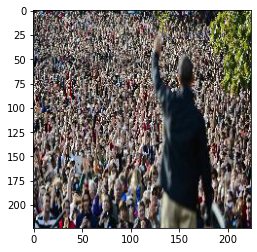

In [63]:
image = get_image('data/train/images/1000.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [64]:
x_train = np.zeros((num_train_images, img_width, img_width, 3), dtype=np.uint8)
y_train = np.zeros((num_train_images, 2), dtype=np.uint8)
x_val = np.zeros((num_val_images, img_width, img_width, 3), dtype=np.uint8)
y_val = np.zeros((num_val_images, 2), dtype=np.uint8)

for i in range(num_train_images):
    # print('train/%s.jpg' % labels['id'][i])
    x_train[i] = get_image('data/train/images/%s.jpg' % labels['id'][i])
    # print(labels['distancing'][i])
    pos = labels['distancing'][i]
    y_train[i][pos] = 1
    # print(y_train[i])
    if(i % 100 == 0): print(i, 'images loaded')
        
for i in range(num_val_images):
    # print('val/%s.jpg' % labels['id'][i])
    x_val[i] = get_image('data/val/images/%s.jpg' % val_labels['id'][i])
    # print(labels['distancing'][i])
    pos = val_labels['distancing'][i]
    y_val[i][pos] = 1
    # print(y_val[i])
    if(i % 100 == 0): print(i, 'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
0 images loaded
100 images loaded
200 images loaded


In [65]:
num_test_images = 300

x_test = np.zeros((num_test_images, img_width, img_width, 3), dtype=np.uint8)
y_test = np.zeros((num_test_images, 2), dtype=np.uint8)

test_labels = pd.read_csv('data/test/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
test_labels.head()

,id,distancing
0,1500,0
1,1501,0
2,1502,0
3,1503,1
4,1504,0


In [66]:
for i in range(num_test_images):
    # print('test/%s.jpg' % labels['id'][i])
    x_test[i] = get_image('data/test/images/%s.jpg' % test_labels['id'][i])
    # print(test_labels['distancing'][i])
    pos = test_labels['distancing'][i] # recall that breed is the array of classes
    y_test[i][pos] = 1
    # print(y_train[i])
    if(i % 100 == 0): print(i, 'images loaded')

0 images loaded
100 images loaded
200 images loaded


In [67]:
x_train_res, x_val_res = resnet50.preprocess_input(x_train), resnet50.preprocess_input(x_val)
res_features = model_resnet50.predict(x_train_res, batch_size=64, verbose=1)
res_val_features = model_resnet50.predict(x_val_res, batch_size=64, verbose=1)
x_train_vgg, x_val_vgg = resnet50.preprocess_input(x_train), resnet50.preprocess_input(x_val)
vgg_features = model_vgg16.predict(x_train_vgg, batch_size=64, verbose=1)
vgg_val_features = model_vgg16.predict(x_val_vgg, batch_size=64, verbose=1)

299/299 [==============================] - 84s 282ms/sample


In [68]:
print(res_features.shape)
print(res_val_features.shape)

(1200, 7, 7, 2048)
(299, 7, 7, 2048)


In [69]:
print(vgg_features.shape)
print(vgg_val_features.shape)

(1200, 7, 7, 512)
(299, 7, 7, 512)


In [70]:
concat_features_train = np.concatenate((res_features, vgg_features), axis=3)
concat_features_val = np.concatenate((res_val_features, vgg_val_features), axis=3)
print(concat_features_train.shape)
print(concat_features_val.shape)

(1200, 7, 7, 2560)
(299, 7, 7, 2560)


In [71]:
inputs = Input(shape = (7, 7, 2560))

# attention layers
a_map = layers.Conv2D(516, 1, strides=(1, 1), padding="same", activation='relu')(inputs)
a_map1 = layers.Conv2D(1, 1, strides=(1, 1), padding="same", activation='relu')(a_map)
a_map2 = layers.Conv2D(2560, 1, strides=(1, 1), padding="same", activation='sigmoid')(a_map1)

res = layers.Multiply()([inputs, a_map2])
# print(res.shape)

atten = layers.Attention()([inputs, res])
# print(atten.shape)

# concat = layers.Concatenate()([res,atten])

x = GlobalAveragePooling2D()(res) # to convert to 2048 feagures
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(2, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.

In [72]:
model = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model.summary()

Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 7, 7, 2560)] 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 516)    1321476     input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 7, 7, 1)      517         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 7, 7, 2560)   5120        conv2d_10[0][0]                  
___________________________________________________________________________________________

In [73]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [74]:
early_stop = EarlyStopping(monitor='val_loss',  patience=10, verbose=1, restore_best_weights=True)

history = model.fit(concat_features_train, y_train, batch_size=64, epochs=30, 
              validation_data=(concat_features_val, y_val), callbacks=[early_stop], verbose=1)

Train on 1200 samples, validate on 299 samples
Epoch 1/30
1200/1200 [==============================] - 8s 7ms/sample - loss: 0.3739 - accuracy: 0.8450 - val_loss: 0.5587 - val_accuracy: 0.8495
Epoch 2/30
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.1912 - accuracy: 0.9308 - val_loss: 0.2507 - val_accuracy: 0.9164
Epoch 3/30
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.1264 - accuracy: 0.9483 - val_loss: 0.2037 - val_accuracy: 0.9264
Epoch 4/30
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.1239 - accuracy: 0.9467 - val_loss: 0.2179 - val_accuracy: 0.9130
Epoch 5/30
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0952 - accuracy: 0.9600 - val_loss: 0.1755 - val_accuracy: 0.9398
Epoch 6/30
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0843 - accuracy: 0.9667 - val_loss: 0.1675 - val_accuracy: 0.9331
Epoch 7/30
1200/1200 [==============================] - 7s 6ms/sample - loss:

In [75]:
model.save('model_combined.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


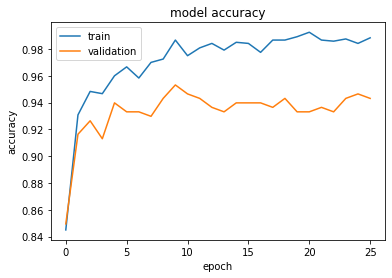

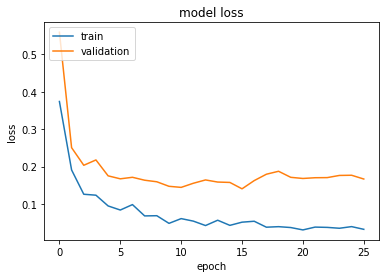

In [76]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

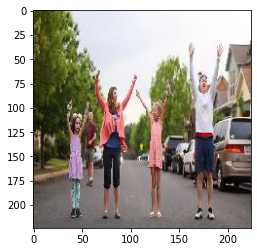

In [77]:
test_img = get_image('data/test/images/1511.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [79]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

x_test_res = resnet50.preprocess_input(image_batch)
res_features = model_resnet50.predict(x_test_res)
x_test_vgg = vgg16.preprocess_input(image_batch)
vgg_features = model_vgg16.predict(x_test_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
pos = np.argmax(predictions)
classes[pos]

'distanced'

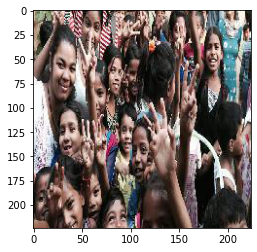

In [80]:
test_img = get_image('data/test/images/1566.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [81]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

x_test_res = resnet50.preprocess_input(image_batch)
res_features = model_resnet50.predict(x_test_res)
x_test_vgg = vgg16.preprocess_input(image_batch)
vgg_features = model_vgg16.predict(x_test_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [82]:
x_test_res = resnet50.preprocess_input(x_test)
res_features = model_resnet50.predict(x_test_res)
x_test_vgg = vgg16.preprocess_input(x_test)
vgg_features = model_vgg16.predict(x_test_vgg)

concat_features = np.concatenate((res_features, vgg_features), axis=3)

predictions = model.predict(concat_features)
type(predictions)

numpy.ndarray

In [83]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 0, 0, 1, 0])

In [84]:
y_truth = np.zeros((num_test_images, 2), dtype=np.uint8)
y_truth[np.arange(y_test.shape[0]), np.argmax(y_test, axis=1)] = 1
y_truth = np.nonzero(y_truth)
y_truth = y_truth[1]
y_truth[:5]

array([0, 0, 0, 1, 0])

In [85]:
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[188  12]
 [  7  93]]


In [86]:
TP, FP, TN, FN = matrix[1,1], matrix[0,1], matrix[0,0], matrix[1,0]
precision_positive = TP/(TP+FP)
print('Precision, Distanced Class: %f' % precision_positive)
recall_positive = TP/(TP+FN)
print('Recall, Distanced Class: %f' % recall_positive)
f1_positive = 2*((precision_positive*recall_positive)/(precision_positive+recall_positive))
print('F1 score, Distanced Class: %f' % f1_positive)

Precision, Distanced Class: 0.885714
Recall, Distanced Class: 0.930000
F1 score, Distanced Class: 0.907317


In [87]:
precision_negative = TN/(TN+FN)
print('Precision, Not Distanced Class: %f' % precision_negative)
recall_negative = TN/(TN+FP)
print('Recall, Not Distanced Class: %f' % recall_negative)
f1_negative = 2*((precision_negative*recall_negative)/(precision_negative+recall_negative))
print('F1 score, Not Distanced Class: %f' % f1_negative)

Precision, Not Distanced Class: 0.964103
Recall, Not Distanced Class: 0.940000
F1 score, Not Distanced Class: 0.951899


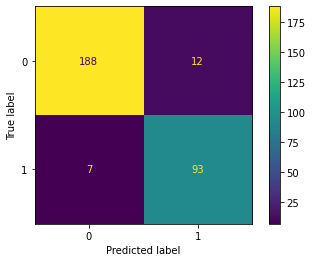

In [88]:
ConfusionMatrixDisplay.from_predictions(y_truth, preds)

In [89]:
def show_image_mask_resnet(image, inputs, atten):
    x = resnet50.preprocess_input(image)
    res_features = model_resnet50.predict(x)
    y = vgg16.preprocess_input(image)
    vgg_features = model_vgg16.predict(y)

    concat = np.concatenate((res_features, vgg_features), axis=3)
    extract = Model(inputs, atten)
    w = extract.predict(concat)
    im_res = np.squeeze(image)[:,:,0]
    
    im_w = np.power(cv.resize(np.mean(w[0], axis=2), (224, 224)),3)
    return np.multiply(im_w, im_res)

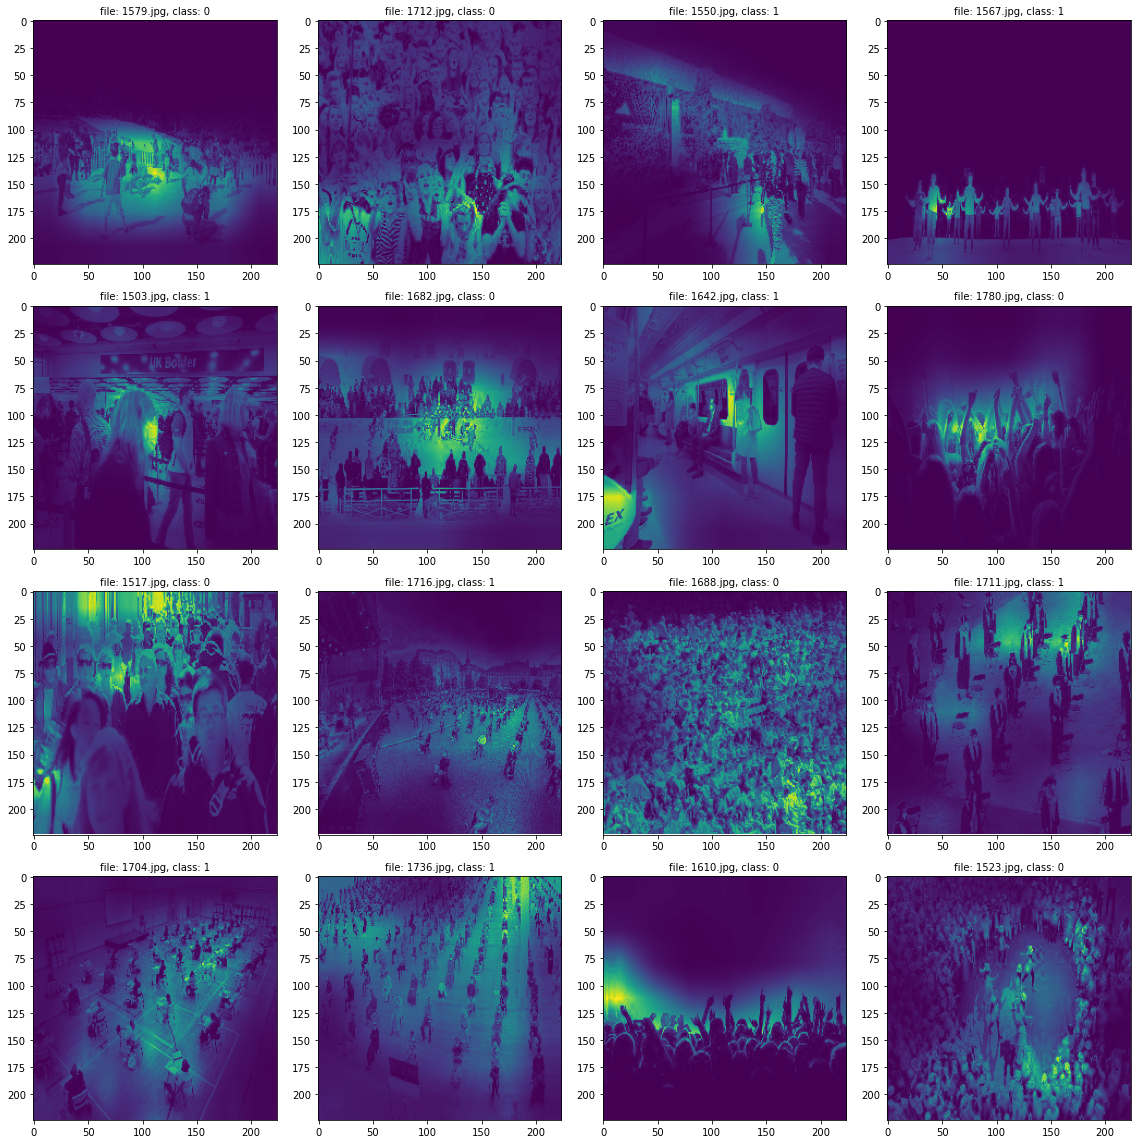

In [90]:
index = np.random.choice(x_test_res.shape[0], 16, replace=False)

counter = 0
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for rows in range(4):
    for columns in range(4):
        im = get_image('data/test/images/%s.jpg' % test_labels['id'][index[counter]])
        im = im[None, :]
        to_show = show_image_mask_resnet(im, inputs, a_map)
        title = f"file: {test_labels['id'][index[counter]]}.jpg, class: {test_labels['distancing'][index[counter]]}"
        ax[rows,columns].set_title(title, fontsize=10)
        ax[rows,columns].imshow(to_show, cmap='viridis')
        counter += 1
plt.tight_layout()
plt.savefig('attention_comb_amap.jpg')
plt.show()

In [ ]:
counter = 0
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for rows in range(4):
    for columns in range(4):
        im = get_image('data/test/images/%s.jpg' % test_labels['id'][index[counter]])
        im = im[None, :]
        to_show = show_image_mask_resnet(im, inputs, a_map1)
        title = f"file: {test_labels['id'][index[counter]]}.jpg, class: {test_labels['distancing'][index[counter]]}"
        ax[rows,columns].set_title(title, fontsize=10)
        ax[rows,columns].imshow(to_show, cmap='viridis')
        counter += 1
plt.tight_layout()
plt.savefig('attention_comb_amap1.jpg')
plt.show()

In [ ]:
counter = 0
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for rows in range(4):
    for columns in range(4):
        im = get_image('data/test/images/%s.jpg' % test_labels['id'][index[counter]])
        im = im[None, :]
        to_show = show_image_mask_resnet(im, inputs, a_map2)
        title = f"file: {test_labels['id'][index[counter]]}.jpg, class: {test_labels['distancing'][index[counter]]}"
        ax[rows,columns].set_title(title, fontsize=10)
        ax[rows,columns].imshow(to_show, cmap='viridis')
        counter += 1
plt.tight_layout()
plt.savefig('attention_comb_amap2.jpg')
plt.show()

In [ ]:
counter = 0
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for rows in range(4):
    for columns in range(4):
        im = get_image('data/test/images/%s.jpg' % test_labels['id'][index[counter]])
        im = im[None, :]
        to_show = show_image_mask_resnet(im, inputs, res)
        title = f"file: {test_labels['id'][index[counter]]}.jpg, class: {test_labels['distancing'][index[counter]]}"
        ax[rows,columns].set_title(title, fontsize=10)
        ax[rows,columns].imshow(to_show, cmap='viridis')
        counter += 1
plt.tight_layout()
plt.savefig('attention_comb_res.jpg')
plt.show()

In [ ]:
counter = 0
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for rows in range(4):
    for columns in range(4):
        im = get_image('data/test/images/%s.jpg' % test_labels['id'][index[counter]])
        im = im[None, :]
        to_show = show_image_mask_resnet(im, inputs, atten)
        title = f"file: {test_labels['id'][index[counter]]}.jpg, class: {test_labels['distancing'][index[counter]]}"
        ax[rows,columns].set_title(title, fontsize=10)
        ax[rows,columns].imshow(to_show, cmap='viridis')
        counter += 1
plt.tight_layout()
plt.savefig('attention_comb_atten.jpg')
plt.show()

In [ ]:
layer_names = []

for layer in model.layers[:]:
  layer_names.append(layer.name)
print(layer_names)

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:]]
activation_model = Model(inputs = model.input, outputs = layer_outputs)

test_img = get_image('data/test/images/1513.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

x_test_res = resnet50.preprocess_input(image_batch)
res_features = model_resnet50.predict(x_test_res)
x_test_vgg = vgg16.preprocess_input(image_batch)
vgg_features = model_vgg16.predict(x_test_vgg)

feature_input = np.concatenate((res_features, vgg_features), axis=3)

activations = activation_model.predict(feature_input)

first_layer_activation = activations[4]
activation_shapes = [activation.shape for activation in activations]
print(activation_shapes)

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 89], cmap ='plasma')

In [ ]:
from tqdm.notebook import tqdm, trange
import time

images_per_row = 64

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in tqdm(range(n_cols)): # Tiles each filter into a big horizontal grid
        if len(layer_activation.shape) == 4 and layer_activation.shape[3] > 1: 
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    plt.show()